In [1]:
!pip install fasttext
!pip install nltk
!pip install memory_profiler
!pip install -U mkl
!pip install -U numpy

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
Requirement already up-to-date: mkl in /usr/local/lib/python3.6/dist-packages (2022.0.2)
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.5)
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


# Экспериментальная часть

In [2]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import Conc>eptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sys import getsizeof
from sys import getrefcount
import gc
import fasttext.util
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow import keras
import random
import matplotlib.pyplot as plt
# import memory_profiler

In [3]:
help(fasttext)

Help on package fasttext:

NAME
    fasttext

DESCRIPTION
    # Copyright (c) 2017-present, Facebook, Inc.
    # All rights reserved.
    #
    # This source code is licensed under the MIT license found in the
    # LICENSE file in the root directory of this source tree.

PACKAGE CONTENTS
    FastText
    tests (package)
    util (package)

DATA
    BOW = '<'
    EOS = '</s>'
    EOW = '>'
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...
    unicode_literals = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', ...

FILE
    /usr/local/lib/python3.6/dist-packages/fasttext/__init__.py




In [4]:
# fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')
porter_stemmer = nltk.stem.PorterStemmer()
tok = CountVectorizer().build_tokenizer()

In [5]:
df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%Y-%m-%d")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all.label = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"
...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",Burned these in before listening to them for a...,5,Boom -- Pop -- Pow. These deliver.,1405555200,"07 17, 2014"
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",Some people like DJ style headphones or earbud...,5,"Thin and light, without compromising on sound ...",1405382400,"07 15, 2014"
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",I&#8217;m a big fan of the Brainwavz S1 (actua...,5,Same form factor and durability as the S1 with...,1405555200,"07 17, 2014"
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]","I've used theBrainwavz S1 In Ear Headphones, a...",5,Superb audio quality in a very comfortable set...,1405641600,"07 18, 2014"


In [6]:
df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
df_all["bin_label"] = df_all.overall > 3
# df_all["label"] = df_all.overall.apply(lambda x: '3' if x == 3 else ('1-2' if x < 3 else '4-5'))
df_all['label'] = df_all.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
0,A1ABVP0DV1ZN89,B00000JBAT,Adam Sacks,"[0, 0]",The RIO rocks! It is so great that Diamond Mul...,5,WOW! THE BEST THING TO HAPPEN TO MUSIC!,929232000,1999-06-13,True,3,the rio rock it is so great that diamond multi...
1,A6ILK3FXYH595,B00000J4FS,kc2kth,"[1, 1]",I have found a few places that will do memory ...,5,After-market Memory Upgrades,931132800,1999-07-05,True,3,have found few place that will do memori upgra...
2,A7RV1KU5O0II9,B00000JFMK,"David S. Saunders ""Equal parts tech geek, bra...","[0, 0]",I love this player! I travel frequently and th...,5,Incredible screen!,931392000,1999-07-08,True,3,love thi player travel frequent and the l50 ke...
3,AJ6TMOHHFJJAJ,B00000JMO4,Ali Navaie,"[5, 5]",If you are looking for the best camcorder in t...,5,Simply the best in the market --- Get it while...,932688000,1999-07-23,True,3,if you are look for the best camcord in the ma...
4,A1JTSRG8SU4VFO,B00000JFE3,L. Goff,"[0, 0]",The &quot;lip-synch&quot; problem has shown up...,5,Own the Sony 550D model,932688000,1999-07-23,True,3,the quot lip synch quot problem ha shown up on...
...,...,...,...,...,...,...,...,...,...,...,...,...
1689183,A9DH6MLZBGUMO,B00J8ZJCUW,Jules,"[0, 0]",I had to order two of these - The GLAZZ was so...,5,10 stars! The PERFECT protection for your iPad...,1406073600,2014-07-23,True,3,had to order two of these the glazz wa so well...
1689184,A1SLHNA3FV9U9E,B00HZVPD72,ashtangakasha,"[0, 0]","Tiny, simple, excellent sound quality, easy to...",4,"Tiny, simple, and effective.",1406073600,2014-07-23,True,3,tini simpl excel sound qualiti easi to set up ...
1689185,A2YQ9AX4GOTA0S,B00BOEG08M,NaN,"[0, 0]",Works great. Very convenient.,5,Five Stars,1406073600,2014-07-23,True,3,work great veri conveni
1689186,A2MUTLXDSV3JRC,B00IERCFFO,"MBW66 ""Pilcopata Man""","[0, 0]",Elegant trim case for iPad Air. No zipper case...,5,Slim case for iPad Air,1406073600,2014-07-23,True,3,eleg trim case for ipad air no zipper case for...


In [7]:
df_by_years = {}
for year in df_all.reviewTime.dt.year.unique().tolist():
    df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
    print(year, len(df_by_years[year]))
    print(df_by_years[year].bin_label.value_counts(), '\n')

1999 72
True     61
False    11
Name: bin_label, dtype: int64 

2000 817
True     686
False    131
Name: bin_label, dtype: int64 

2001 1609
True     1292
False     317
Name: bin_label, dtype: int64 

2002 2315
True     1802
False     513
Name: bin_label, dtype: int64 

2003 3547
True     2663
False     884
Name: bin_label, dtype: int64 

2004 5159
True     3655
False    1504
Name: bin_label, dtype: int64 

2005 9638
True     6994
False    2644
Name: bin_label, dtype: int64 

2006 15447
True     11528
False     3919
Name: bin_label, dtype: int64 

2007 35976
True     28404
False     7572
Name: bin_label, dtype: int64 

2008 49872
True     39460
False    10412
Name: bin_label, dtype: int64 

2009 70666
True     55304
False    15362
Name: bin_label, dtype: int64 

2010 103797
True     80475
False    23322
Name: bin_label, dtype: int64 

2011 173395
True     134860
False     38535
Name: bin_label, dtype: int64 

2012 282942
True     224559
False     58383
Name: bin_label, dtype: int64 

2

In [8]:
samples_number = 7
skf = StratifiedKFold(n_splits=samples_number)
data_by_year_splitted = {}
for year in range(2007, 2015):
    data_tmp = df_by_years[year].sample(35000)
    data_list, labels_list = [], []
    
    for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
        data = data_tmp.iloc[test_index]
        data_list.append(data.words)
        labels_list.append(data.label)
        
    data_by_year_splitted[year] = {'data': data_list, 'labels': labels_list}
    print(year)

2007
2008
2009
2010
2011
2012
2013
2014


In [9]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))
df_tvd_lstm = df_accuracy.copy()
df_js_lstm = df_accuracy.copy()
df_ks_lstm = df_accuracy.copy()
df_tvd_tfidf = df_accuracy.copy()
df_js_tfidf = df_accuracy.copy()
df_ks_tfidf = df_accuracy.copy()
df_tvd_count = df_accuracy.copy()
df_js_count = df_accuracy.copy()
df_ks_count = df_accuracy.copy()
df_perc_no_zero = df_accuracy.copy()
df_accuracy_keras = df_accuracy.copy()
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [10]:
def generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
        
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [ ]:
for year_train in range(2007, 2015):
    for test_index in range(samples_number):
        print('step 1')
        vecotrizer_tfidf = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vecotrizer_count = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        tokenizer = Tokenizer(num_words=100000, lower=True, char_level=False)
        train_data = pd.Series(dtype=pd.StringDtype())
        train_labels = pd.Series(dtype=int)
        
        print('step 2')
        for train_index in range(samples_number):
            if test_index != train_index:
                train_data = train_data.append(data_by_year_splitted[year_train]['data'][train_index])
                train_labels = train_labels.append(data_by_year_splitted[year_train]['labels'][train_index])
        
        print('step 3')
        tokenizer.fit_on_texts(train_data)
        word_index = tokenizer.word_index
        nb_words = min(100000, len(word_index))
        train_data = sequence.pad_sequences(tokenizer.texts_to_sequences(train_data), maxlen = nb_words)
        embedding_matrix = np.zeros((nb_words, 300))
        for word, i in word_index.items():
            if i >= nb_words:
                continue
            try:
                embedding_vector = ft.get_word_vector(word)
            except KeyError:
                embedding_vector = None
            if (embedding_vector is not None) and len(embedding_vector) > 0:
                embedding_matrix[i] = embedding_vector
        
        print('step 4')
        inputs = keras.Input(shape=(train_data.shape[1],))
        x = Embedding(nb_words, 300,input_length=train_data.shape[1], weights=[embedding_matrix],trainable=False)(inputs)
        outputs_dist = Bidirectional(LSTM(32))(x)
        distribution_model = keras.Model(inputs=inputs, outputs=outputs_dist, name="distribution")

        y = Dense(32,activation='relu')(outputs_dist)
        outputs = Dense(4,activation='softmax')(y)
        model = keras.Model(inputs=inputs, outputs=outputs, name="model")
        
        print('step 5')
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=["accuracy"],
        )
        
        print('step 6')
        batch_size = 16
        gen = generator(train_data, to_categorical(train_labels), batch_size)
        print('Start fitting')
        model.fit(
                gen,
                epochs=1,
                steps_per_epoch = train_data.shape[0]//batch_size)
        print('Finish fitting')
        
        print('step 7')
        
        lstm_dist_train = np.mean(distribution_model.predict(train_data), axis = 0)
        tfidf_dist_train = np.mean(vecotrizer_tfidf.fit_transform(train_data), axis = 0)
        count_dist_train = np.mean(vecotrizer_count.fit_transform(train_data), axis = 0)
        
        for year_test in range(year_train, 2015):
            
            test_data = sequence.pad_sequences(tokenizer.texts_to_sequences(data_by_year_splitted[year_test]['data'][test_index]), maxlen = train_data.shape[1])
            test_labels = data_by_year_splitted[year_test]['labels'][test_index]
            
            loss, accuracy = model.evaluate(test_data.toarray(), to_categorical(test_labels), verbose=False)
            df_accuracy.loc[year_train][year_test][test_index] = accuracy
            
            lstm_dist_test = np.mean(distribution_model.predict(test_data), axis = 0)
            tfidf_dist_test = np.mean(vecotrizer_tfidf.transform(test_data), axis = 0)
            count_dist_test = np.mean(vecotrizer_count.transform(test_data), axis = 0)            
            
            df_tvd_lstm = sum(abs(lstm_dist_train - lstm_dist_test))/2
            df_js_lstm = jensenshannon(lstm_dist_train, lstm_dist_test)
            df_ks_lstm = ks_2samp(lstm_dist_train, lstm_dist_test).statistic
            df_tvd_tfidf = sum(abs(tfidf_dist_train - tfidf_dist_test))/2
            df_js_tfidf = jensenshannon(tfidf_dist_train, tfidf_dist_test)
            df_ks_tfidf = ks_2samp(tfidf_dist_train, tfidf_dist_test).statistic
            df_tvd_count = sum(abs(count_dist_train - count_dist_test))/2
            df_js_count = jensenshannon(count_dist_train, count_dist_test)
            df_ks_count = ks_2samp(count_dist_train, count_dist_test).statistic
            df_perc_no_zero = np.count_nonzero(count_dist_test)/np.count_nonzero(count_dist_test)            
            
            print("Train in {0}, test in {1}, test sample {2}\naccuracy_score = {3}".format(year_train, year_test, test_index, df_accuracy.loc[year_train][year_test][test_index]))
            del test_data
            del test_labels
            del loss
            del accuracy
            gc.collect()
        
        print('step 8')
        clear_session()
        del model
        del train_data
        del train_labels
        del gen
        del tokenizer
        del vecotrizer_tfidf
        del vecotrizer_count
        del input_dim
        gc.collect()

step 1
step 2
step 3
step 4
step 5
step 6
Start fitting
  ...
    to  
  ['...']
Train for 1875 steps
1368/1875 [====================>.........] - ETA: 11:25 - loss: 0.6624 - accuracy: 0.7887

### 3 метки

In [ ]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [ ]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

In [ ]:
df_mean_values(df_tvd)

In [15]:
df_mean_values(df_js)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.101,0.0993,0.0931,0.0806,0.0631,0.0389,0.00948,0.0
2008,,0.1,0.0974,0.0861,0.0691,0.0442,0.0129,0.00324
2009,,,0.1,0.0924,0.0764,0.0512,0.0183,0.00841
2010,,,,0.101,0.0897,0.066,0.0322,0.0219
2011,,,,,0.101,0.0825,0.0491,0.0389
2012,,,,,,0.0998,0.0711,0.0618
2013,,,,,,,0.0991,0.0924
2014,,,,,,,,0.0994


In [16]:
df_mean_values(df_ks)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.171,0.176,0.173,0.157,0.13,0.0829,0.0182,0.00377
2008,,0.168,0.169,0.154,0.128,0.0807,0.0139,0.0
2009,,,0.17,0.157,0.132,0.0849,0.0167,0.00337
2010,,,,0.17,0.149,0.102,0.0327,0.0179
2011,,,,,0.171,0.128,0.0591,0.0438
2012,,,,,,0.172,0.105,0.0897
2013,,,,,,,0.177,0.162
2014,,,,,,,,0.175


In [17]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,90.946%,91.360%,91.257%,89.924%,87.577%,83.652%,76.459%,74.141%
2008,,90.877%,91.081%,89.804%,87.509%,83.461%,75.971%,73.636%
2009,,,90.963%,89.935%,87.730%,83.696%,76.004%,73.657%
2010,,,,91.023%,89.270%,85.473%,77.936%,75.627%
2011,,,,,90.990%,87.892%,80.896%,78.628%
2012,,,,,,90.966%,84.956%,82.964%
2013,,,,,,,90.962%,89.522%
2014,,,,,,,,90.870%


## Сorrelation

In [18]:
def transform_df_to_arr(df):
    arr = df.to_numpy().reshape(7*8*8,)
    arr = arr[arr != 0]
    return(arr)

def search_correlation(df_1, df_2):
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.scatter(arr_1, arr_2)
    return(np.corrcoef(arr_1, arr_2)[0, 1])

0.2881040817388011

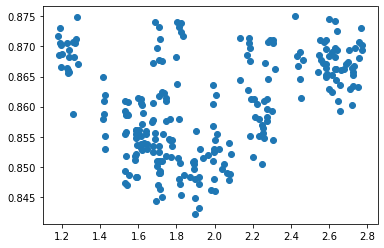

In [19]:
search_correlation(df_tvd, df_accuracy)

0.4818878506990767

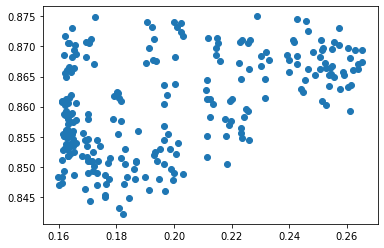

In [20]:
search_correlation(df_js, df_accuracy)

0.5485302231317442

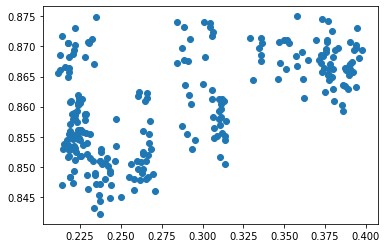

In [21]:
search_correlation(df_ks, df_accuracy)

-0.577220903634106

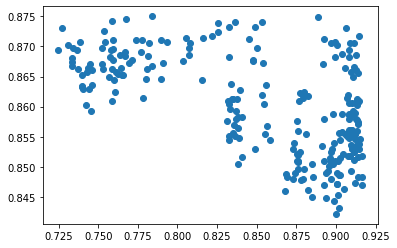

In [39]:
search_correlation(df_perc_no_zero, df_accuracy)

## Keras

In [12]:
train_data, test_data = train_test_split(df_by_years[2011], train_size = 30000, test_size = 5000, stratify = df_by_years[2011]['label'])

In [13]:
train_data.label = train_data.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
test_data.label = test_data.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
train_data

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
6346,A13EODCMGOHC4U,B003VAK1I2,CJH in A2,"[1, 1]","This unit works real well, I purchased for my ...",5,Really great value!,1294963200,2011-01-14,True,3,thi unit work real well purchas for my daughte...
153496,AN81JUYW2SL24,B005Q3142E,Gearhead Mania,"[1, 2]",Motorola MotoACTV wrist strapI used this wrist...,5,Best way to use the MotoACTV,1322870400,2011-12-03,True,3,motorola motoactv wrist strapi use thi wrist s...
45429,A31EE4G7VHLJIF,B003EAS5SW,"Gar ""garp36""","[6, 6]",I ordered this adapter so that I could use len...,5,Lens Adaptor for Lumix DMC-G1,1303257600,2011-04-20,True,3,order thi adapt so that could use len from my ...
105840,A3VP5K2LJKZFO3,B003C1AO2I,BuffaloPhil,"[0, 0]","I have a small apartment, and needed a sound b...",4,Solid choice for a sound bar.,1315180800,2011-09-05,True,3,have small apart and need sound bar system wit...
52472,A1D1L6VZ70J4KG,B001DBF07I,Conrad D. Shull,"[0, 0]",I've had no negative quality or performance is...,5,"It's just a USB hub, but I like it a lot",1304640000,2011-05-06,True,3,ve had no neg qualiti or perform issu it exter...
...,...,...,...,...,...,...,...,...,...,...,...,...
79763,A39S5K5NKPU44H,B0032R6CPK,MrsC,"[0, 0]",This is an essential cooling pad for laptops. ...,4,essential cooling for laptop,1310342400,2011-07-11,True,3,thi is an essenti cool pad for laptop the plas...
61419,A45D2LMO2GI50,B001RKDEVE,Roger,"[0, 0]",This is a great package to have for portabilit...,5,Very happy with this package,1306540800,2011-05-28,True,3,thi is great packag to have for portabl for th...
155140,A3JCWGHCVC2ZNF,B005X64OQW,Sheri in Reho,"[24, 24]","When I ordered this, it was described as a HAR...",3,It was listed as a HARD CASE and isn't really.,1323129600,2011-12-06,False,2,when order thi it wa describ as hard case for ...
111694,AD340HMJE1IU7,B0002Q7TME,bistwo,"[1, 2]",works fine for things like keyboards and print...,3,very low bandwidth.,1316131200,2011-09-16,False,2,work fine for thing like keyboard and printer ...


In [14]:
vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
# X_train, Y_train = vecotrizer.fit_transform(train_data['words'].apply(lambda x: np.str_(x))), train_data['label']
# X_test, Y_test = vecotrizer.transform(test_data['words'].apply(lambda x: np.str_(x))), test_data['label']

X_train, Y_train = train_data['words'].apply(lambda x: np.str_(x)), train_data['label']
X_test, Y_test = test_data['words'].apply(lambda x: np.str_(x)), test_data['label']

In [15]:
def generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

#         X_batch = np.array(X_data.iloc[batch_size*counter:batch_size*(counter+1)]).astype('float32')
#         y_batch = np.array(y_data.iloc[batch_size*counter:batch_size*(counter+1)]).astype('float32')

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
        counter += 1
        yield X_batch,y_batch
        
        if counter >= number_of_batches:
            counter = 0

In [16]:
ft = fasttext.load_model('cc.en.300.bin')
tokenizer = Tokenizer(num_words=100000, lower=True, char_level=False)
tokenizer.fit_on_texts(df_by_years[2011]['words'])
X_train = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train))
X_test = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = X_train.shape[1])
max_len = max([len(x) for x in X_train])
word_index = tokenizer.word_index
X_train.shape[1] == X_test.shape[1]

True

In [17]:
words_not_found = []
word_index = tokenizer.word_index
nb_words = min(100000, len(word_index))
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = ft.get_word_vector(word)
    except KeyError:
        embedding_vector = None
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        print('words not found: ', word)
print(f"Null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")

Null word embeddings: 1


In [102]:
model = tf.keras.Sequential()

model.add(Embedding(100000,300,input_length=max_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(4,activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 5349, 300)         30000000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 30,087,460
Trainable params: 87,460
Non-trainable params: 30,000,000
_________________________________________________________________


In [18]:
inputs = keras.Input(shape=(max_len,))
x = Embedding(100000,300,input_length=max_len, weights=[embedding_matrix],trainable=False)(inputs)
outputs_dist = Bidirectional(LSTM(32))(x)
distribution_model = keras.Model(inputs=inputs, outputs=outputs_dist, name="distribution")

y = Dense(32,activation='relu')(outputs_dist)
outputs = Dense(4,activation='softmax')(y)
model = keras.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5361)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 5361, 300)         30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 

In [19]:
distribution_model.summary()

Model: "distribution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5361)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 5361, 300)         30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
Total params: 30,085,248
Trainable params: 85,248
Non-trainable params: 30,000,000
_________________________________________________________________


In [ ]:
%%time
batch_size = 32
history = model.fit(
                generator(X_train,to_categorical(Y_train), batch_size),
                epochs=1,
                steps_per_epoch = X_train.shape[0]/batch_size,
                validation_data = generator(X_test,to_categorical(Y_test),batch_size*2),
                validation_steps = (X_test.shape[0]/batch_size*2)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 38/937 [>.............................] - ETA: 1:12:43 - loss: 0.8935 - acc: 0.7574

In [157]:
np.mean(distribution_model.predict(X_test[0:5]), axis = 0)

array([-0.64589727,  0.58102167,  0.55233395,  0.39116877, -0.62356865,
       -0.506135  , -0.17011988, -0.4935368 , -0.62266225,  0.56397504,
       -0.57334644,  0.13772558,  0.51872945,  0.49975935, -0.48661107,
        0.39427444,  0.35603285,  0.59981644, -0.37038046,  0.09983164,
       -0.4670748 , -0.14803378,  0.2482619 ,  0.45509022,  0.02359201,
        0.51316077, -0.00515087, -0.29934153,  0.580619  , -0.56113154,
        0.06063815,  0.56700456,  0.02619551, -0.024526  ,  0.01604969,
       -0.04203767, -0.02042491, -0.03954846, -0.0395518 , -0.03688935,
       -0.06447953,  0.04128954, -0.03790034,  0.03851786,  0.02903102,
       -0.03322716, -0.0055628 , -0.05581734, -0.04601864, -0.00284361,
       -0.04284932, -0.03921444,  0.0304521 ,  0.0600859 , -0.05434576,
       -0.00732344, -0.03741178,  0.04145479, -0.03864665,  0.05795066,
       -0.0019982 ,  0.02106619,  0.06548478,  0.04305499], dtype=float32)

In [160]:
np.mean(distribution_model.predict(X_test[0:5]), axis = 0)

array([-0.48340616,  0.6490822 ,  0.16316198,  0.20996651, -0.47445554,
       -0.361836  , -0.27049997, -0.51924884, -0.53923064,  0.5785738 ,
       -0.54489493,  0.06186327,  0.5240135 ,  0.18179782, -0.47820243,
        0.05255185,  0.17440832,  0.54029405, -0.07358305,  0.11176876,
       -0.0260424 , -0.11016241,  0.06558194,  0.13931069, -0.149551  ,
        0.42235875, -0.00704895, -0.1416152 ,  0.27947944, -0.5202483 ,
        0.01687913,  0.4181192 ,  0.02961318,  0.00136268,  0.01675408,
       -0.06225523, -0.01433572, -0.04293685, -0.02700353, -0.01144101,
       -0.03336453,  0.03453464, -0.00970715,  0.01570471,  0.02343618,
       -0.01343108, -0.00221851, -0.04809297, -0.03200098, -0.00967022,
       -0.02164816, -0.05031835,  0.03715852,  0.02048345, -0.02475187,
       -0.00667347, -0.02684664,  0.05596768, -0.0440798 ,  0.11591764,
        0.00181182,  0.00458665,  0.02712201,  0.02099751], dtype=float32)

In [150]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

print(model.summary())
plot_history(history)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 5349)]            0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 5349, 300)         30000000  
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                85248     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 132       
Total params: 30,087,460
Trainable params: 87,460
Non-trainable params: 30,000,000
_________________________________________________________________
None


NameError: name 'history' is not defined

In [ ]:
clear_session()
del model
del history
del loss
del accuracy
gc.collect()

In [ ]:
gc